# 최종 이미지 분석

### OCR 클래스

In [1]:
import easyocr
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from PIL import ImageFont, ImageDraw, Image

from konlpy.tag import Kkma

class Ocr:
    def __init__(self, img):
        self.img = img

    def text_detect(self):  # 텍스트 검출
        # img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        
        reader = easyocr.Reader(['ko', 'en'], gpu = True)
        result = reader.readtext(self.img)

        # img = cv2.resize(img_cv2, (320, 448))
        image = Image.fromarray(self.img)
        font = ImageFont.truetype('C:/Users/tjoeun/AppData/Local/Microsoft/Windows/Fonts/NanumGothicBold.ttf', 10)
        draw = ImageDraw.Draw(image)
        np.random.seed(42)
        COLORS = np.random.randint(0, 255, size=(255, 3),dtype="uint8")
        for i in result :
            x = i[0][0][0] 
            y = i[0][0][1] 
            w = i[0][1][0] - i[0][0][0] 
            h = i[0][2][1] - i[0][1][1]

            color_idx = random.randint(0,255) 
            color = [int(c) for c in COLORS[color_idx]]

            draw.rectangle(((x, y), (x+w, y+h)), outline=tuple(color), width=2)
            draw.text((int((x + x + w) / 2) , y-2),str(i[1]), font=font, fill=tuple(color),)

        # plt.figure(figsize=(10,20))
        plt.imshow(image)
        plt.axis("off")
        plt.show()
        # print(result)

    def image_to_text(self):    # 검출된 텍스트 영역애 다양한 이미지 필터 적용 후 텍스트 추출
        # 추출된 텍스트 영역을 이용하여 각각의 텍스트를 잘라내고 EasyOCR을 다시 적용
        reader = easyocr.Reader(['ko', 'en'], gpu=True)
        result = reader.readtext(self.img)
        
        origin_results = []
        roi_results = []
        roi_gray_results =[]
        roi_2_results =[]
        roi_equal_results =[]
        roi_dil_results =[]
        roi_ero_results =[]
        roi_canny_results =[]

        for (box, text, confidence) in result:
            try:
                origin_results.append(text)
            except:
                pass

            # 각 텍스트 박스의 좌표 추출
            (startX, startY) = box[0]
            (endX, endY) = box[2]
            
            # 좌표를 정수로 변환
            startX, startY, endX, endY = int(startX), int(startY), int(endX), int(endY)

            # print(startX, startY, endX, endY)
            # 좌표가 음수이거나 이미지 범위를 벗어나는 경우 무시
            if startX < 0 or startY < 0 or endX >= self.img.shape[1] or endY >= self.img.shape[0]:
                continue

            # 텍스트 영역 추출
            roi = self.img[startY:endY, startX:endX]

            ############################################# 이미지 전처리 ###################################################

            # 이미지를 그레이스케일로 변환
            roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

            # 적응형 이진화 수행
            roi_adaptive_thresh = cv2.adaptiveThreshold(roi_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 2)

            # 히스토그램 평탄화 수행
            roi_equalized = cv2.equalizeHist(roi_gray)

            # 팽창
            kernel = np.ones((3, 3), np.uint8)
            roi_dilation = cv2.dilate(roi, kernel, iterations=1)

            # 침식
            kernel = np.ones((3, 3), np.uint8)
            roi_erosion = cv2.erode(roi, kernel, iterations=1)

            # 캐니
            roi_canny = cv2.Canny(roi, 475, 500, apertureSize=3, L2gradient=True)

            ############################################# 텍스트 인식 ###################################################

            # 잘라낸 텍스트 영역에 EasyOCR을 적용
            roi_result = reader.readtext(roi)
            roi_gray_result = reader.readtext(roi_gray)
            roi_2_result = reader.readtext(roi_adaptive_thresh)
            roi_equal_result = reader.readtext(roi_equalized)
            roi_dil_result = reader.readtext(roi_dilation)
            roi_ero_result = reader.readtext(roi_erosion)
            roi_canny_result = reader.readtext(roi_canny)

            ############################################# 결과 출력 ###################################################

            # print("부분")
            # plt.imshow(roi)
            try:
                # print(f'Text: {roi_result[0][1]}, Confidence: {roi_result[0][2]}')
                roi_results.append(roi_result[0][1])
            except:
                # print("Not Detect")
                roi_results.append('None')
            # plt.axis('off')
            # plt.show()

            # print("그레이 스케일")
            # plt.imshow(roi_gray, cmap="gray")
            try:
                # print(f'Text: {roi_gray_result[0][1]}, Confidence: {roi_gray_result[0][2]}')
                roi_gray_results.append(roi_gray_result[0][1])
            except:
                # print("Not Detect")
                roi_gray_results.append('None')
            # plt.axis('off')
            # plt.show()

            # print("적응형 이진화")
            # plt.imshow(roi_adaptive_thresh, cmap="gray")
            try:
                # print(f'Text: {roi_2_result[0][1]}, Confidence: {roi_2_result[0][2]}')
                roi_2_results.append(roi_2_result[0][1])
            except:
                # print("Not Detect")
                roi_2_results.append('None')
            # plt.axis('off')
            # plt.show()

            # print("히스토그램 평탄화")
            # plt.imshow(roi_equalized)
            try:
                # print(f'Text: {roi_equal_result[0][1]}, Confidence: {roi_equal_result[0][2]}')
                roi_equal_results.append(roi_equal_result[0][1])
            except:
                # print("Not Detect")
                roi_equal_results.append('None')
            # plt.axis('off')
            # plt.show()

            # print("팽창")
            # plt.imshow(roi_dilation)
            try:
                # print(f'Text: {roi_dil_result[0][1]}, Confidence: {roi_dil_result[0][2]}')
                roi_dil_results.append(roi_dil_result[0][1])
            except:
                # print("Not Detect")
                roi_dil_results.append('None')
            # plt.axis('off')
            # plt.show()

            # print("침식")
            # plt.imshow(roi_erosion)
            try:
                # print(f'Text: {roi_ero_result[0][1]}, Confidence: {roi_ero_result[0][2]}')
                roi_ero_results.append(roi_ero_result[0][1])
            except:
                # print("Not Detect")
                roi_ero_results.append('None')
            # plt.axis('off')
            # plt.show()

            # print("캐니")
            # plt.imshow(roi_canny)
            try:
                # print(f'Text: {roi_canny_result[0][1]}, Confidence: {roi_canny_result[0][2]}')
                roi_canny_results.append(roi_canny_result[0][1])
            except:
                # print("Not Detect")
                roi_canny_results.append('None')
            # plt.axis('off')
            # plt.show()
        return origin_results, roi_results, roi_gray_results, roi_2_results, roi_equal_results, roi_dil_results, roi_ero_results, roi_canny_results


class GetNouns:
    def __init__(self, i2t_text):
        self.text = i2t_text

    def get_nouns(self):    # 명사 추출
        kkma = Kkma()
        nouns = kkma.nouns(str(self.text))
        return nouns

    def get_nouns_list(self):   # 명사 리스트 생성
        i2t_nouns = self.get_nouns()

        noun_list = []

        # 추출된 명사 출력
        for i2t_noun in i2t_nouns:
            if len(i2t_noun) > 1:
                noun_list.append(i2t_noun)

        noun_list = list(set(noun_list))
        return noun_list
    
    def get_nouns_freq(self, act_nouns, ani_nouns, com_nouns, dra_nouns, hor_nouns, etc_nouns): # 장르별 단어 빈도수 출력
        self.act_nouns = act_nouns
        self.ani_nouns = ani_nouns
        self.com_nouns = com_nouns
        self.dra_nouns = dra_nouns
        self.hor_nouns = hor_nouns
        self.etc_nouns = etc_nouns

        nouns = self.get_nouns_list()
        
        act_freq = 0
        ani_freq = 0
        com_freq = 0
        dra_freq = 0
        hor_freq = 0
        # etc_freq = 0

        # 입력한 단어들의 빈도수 확인
        try:
            for word in nouns:
                if word in self.act_nouns:
                    act_freq += 1
                elif word in self.ani_nouns:
                    ani_freq += 1
                elif word in self.com_nouns:
                    com_freq += 1
                elif word in self.dra_nouns:
                    dra_freq += 1
                elif word in self.hor_nouns:
                    hor_freq += 1
                else:
                    # etc_freq += 1
                    pass
        except:
            pass
        
        return act_freq, ani_freq, com_freq, dra_freq, hor_freq
    
    def read_file(self, file_path):
        self.file_path = file_path

        words = []
        with open(self.file_path, 'r', encoding='utf-8') as file:
            for line in file:
                # 줄바꿈 문자를 제거하고 단어를 리스트에 추가
                word = line.strip()
                words.append(word)
        return words

### 이미지 특징 클래스

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

from ultralytics import YOLO


class ImageCharacteristic:
    def __init__(self, img):
        self.img = img
    
    def show_origin(self):   # 원본 이미지, 크기 출력
        img = self.img
        # img_rgb = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)

        plt.imshow(img)
        plt.axis("off")
        plt.show()

        print(img.shape)

    def color_hist(self):    # 원본 이미지 색 히스토그램 출력
        img_rgb = self.img
        img_gray = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)

        # 그레이 이미지의 0번 채널에 대한 히스토그램 계산
        hist = cv2.calcHist([img_gray], [0], None, [256], [0, 256])

        # RGB 이미지의 각 채널에 대한 히스토그램 계산
        hist_b = cv2.calcHist([img_rgb], [0], None, [256], [0, 256])
        hist_g = cv2.calcHist([img_rgb], [1], None, [256], [0, 256])
        hist_r = cv2.calcHist([img_rgb], [2], None, [256], [0, 256])

        # 히스토그램 시각화
        plt.figure(figsize=(8, 6))
        plt.title('Color Histogram')
        plt.xlabel('Color Value')
        plt.ylabel('Frequency')

        # 그레이 히스토그램 채우기
        plt.fill_between(range(256), hist.flatten(), color='k', alpha=0.4, label='Histogram')

        # RGB 채널 히스토그램 그래프 그리기
        plt.plot(hist_b, color='b', label='Blue Channel')
        plt.plot(hist_g, color='g', label='Green Channel')
        plt.plot(hist_r, color='r', label='Red Channel')

        plt.xlim([0, 256])
        plt.legend()
        plt.show()

    def brightness(self):   # 원본 이미지 밝기 계산
        img_gray = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img_gray, (500, 750))  # (가로, 세로)

        brightness_value = round(img.mean() / 255 , 4)
        # print(f"이미지 밝기 : {brightness_value}")

        return brightness_value
    
    def main_5_color(self):  # 원본 이미지 대표 색상 5개 rgb 값 반환
        main_5_color_list = []

        # 이미지 데이터를 1차원 배열로 변환
        img_flat = self.img.reshape((-1, 3))

        # K-means 클러스터링 모델 생성
        kmeans = KMeans(n_clusters=5)

        # 클러스터링 수행
        kmeans.fit(img_flat)

        # 클러스터 중심을 얻어오고 이를 정수로 변환
        colors = kmeans.cluster_centers_.astype(int)

        # BGR에서 RGB로 변환
        colors_rgb = colors[:, [2, 1, 0]]

        # 주요 색상 출력
        # print("주요 색상 (RGB):")
        for color in colors_rgb:
            # print(color)
            main_5_color_list.append(color)

        # 색상 팔레트 생성
        # color_palette = np.zeros((50, 120, 3), dtype=np.uint8)
        # for i, color in enumerate(colors_rgb):
        #     color_palette[:, i * 40:(i + 1) * 40, :] = color

        # 이미지 표시
        # plt.imshow(color_palette)
        # plt.axis('off')
        # plt.show()

        return main_5_color_list
    
    def image_segmentation(self):   # 이미지 segmentation으로 개체 분류
        '''
        모델 호출
        '''
        # new_model = YOLO('c:/3rd_project/runs/segment/train10/weights/best.pt')   # Mask 모델
        new_model = YOLO('c:/3rd_project/yolov8_pt/230928_new_best.pt')   # Mask 모델
        # new_model = YOLO('c:/3rd_project/yolov8_pt/yolov8n-seg.pt')   # Mask 모델

        '''
        이미지 적용
        '''
        # img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image = cv2.resize(self.img, (320, 448))  # (가로, 세로)
        results = list(new_model.predict(source=image,
                                        conf=0.3, show=False, stream=True))
        #                                 예측률0.5초과                      detect할 클래스만 classes=[0, 2, ...] 추가
        #                                                                   없는 경우 생략

        '''
        이미지 출력
        '''
        res_plotted = results[0].plot()
        plt.imshow(res_plotted)
        # cv2.waitKey()
        # cv2.destroyAllWindows()
        plt.axis('off')
        plt.show()

        '''
        개체 수 출력
        '''
        # gpu => cpu
        cls_cpu = results[0].boxes.cls.to('cpu').to(int)
        # cpu => list
        cls_list = cls_cpu.tolist()

        from collections import Counter

        cls_counts = Counter(cls_list)
        # print(cls_counts)

        # 클래스 이름과 개수를 연결하는 딕셔너리 생성
        ditect_class_names = {
            new_model.names[class_idx]: str(count)
            for class_idx, count in cls_counts.items()
        }

        # 클래스 단순화(81 > 13)
        vehicle = 0
        food = 0
        animal = 0
        bird = 0
        person = 0
        objects = 0
        electronic_products = 0
        computer = 0
        sport = 0
        weapon = 0
        eating_utensil = 0
        bag = 0
        etc = 0
        
        for key, value in ditect_class_names.items():
            value = int(value)
            
            if key in ['airplane', 'bicycle', 'boat', 'bus', 'car', 'motorcycle', 'train', 'truck']:
                vehicle += value
            elif key in ['apple', 'banana', 'broccoli', 'cake', 'carrot', 'donut', 'hot dog', 'orange', 'pizza', 'sandwich']:
                food += value
            elif key in ['bear', 'cat', 'cow', 'dog', 'elephant', 'giraffe', 'horse', 'sheep', 'teddy bear', 'zebra']:
                animal += value
            elif key in ['bird']:
                bird += value
            elif key in ['person']:
                person += value
            elif key in ['bed', 'bench', 'book', 'chair', 'clock', 'couch', 'dining table', 'potted plant', 'suitcase', 'remote',  'tie', 'toilet', 'toothbrush', 'umbrella', 'vase']:
                objects += value
            elif key in ['cell phone', 'hair drier', 'microwave', 'oven', 'refrigerator', 'toaster', 'tv']:
                electronic_products += value
            elif key in ['keyboard', 'laptop', 'mouse']:
                computer += value
            elif key in ['baseball bat', 'baseball glove', 'frisbee', 'skateboard', 'skis', 'snowboard', 'sports ball', 'surfboard', 'tennis racket']:
                sport += value
            elif key in ['knife', 'scissors', 'gun']:
                weapon += value
            elif key in ['bottle', 'bowl', 'cup', 'fork', 'spoon', 'wine glass', 'sink']:
                eating_utensil += value
            elif key in ['backpack',  'handbag']:
                bag += value
            else:
                etc += value
        
        return vehicle, food, animal, bird, person, objects, electronic_products, computer, sport, weapon, eating_utensil, bag, etc

### 데이터 전처리 클래스

In [3]:
class DataProcessing:
    def __init__(self):
        pass
    
    def change_data(self, text_freq, brightness, main_5_colors, i_s):
        self.text_freq = list(text_freq)
        self.brightness = brightness
        self.main_5_colors = main_5_colors
        self.i_s = list(i_s)

        color_1 = self.main_5_colors[0].tolist()
        color_2 = self.main_5_colors[1].tolist()
        color_3 = self.main_5_colors[2].tolist()
        color_4 = self.main_5_colors[3].tolist()
        color_5 = self.main_5_colors[4].tolist()

        color_1_r = round(color_1[0] / 255, 4)
        color_1_g = round(color_1[1] / 255, 4)
        color_1_b = round(color_1[2] / 255, 4)
        color_2_r = round(color_2[0] / 255, 4)
        color_2_g = round(color_2[1] / 255, 4)
        color_2_b = round(color_2[2] / 255, 4)
        color_3_r = round(color_3[0] / 255, 4)
        color_3_g = round(color_3[1] / 255, 4)
        color_3_b = round(color_3[2] / 255, 4)
        color_4_r = round(color_4[0] / 255, 4)
        color_4_g = round(color_4[1] / 255, 4)
        color_4_b = round(color_4[2] / 255, 4)
        color_5_r = round(color_5[0] / 255, 4)
        color_5_g = round(color_5[1] / 255, 4)
        color_5_b = round(color_5[2] / 255, 4)

        # # 리스트 내의 요소를 실수로 변환
        text_freq = [float(x) for x in self.text_freq]
        i_s = [float(x) for x in self.i_s]

        input_data_list = []
        input_data_list.extend(i_s)
        input_data_list.extend([brightness, color_1_r, color_1_g, color_1_b, color_2_r, color_2_g, color_2_b,
                                color_3_r, color_3_g, color_3_b, color_4_r, color_4_g, color_4_b, color_5_r, color_5_g, color_5_b])
        input_data_list.extend(text_freq)
        # print(len(input_data_list))
        # print(input_data_list)

        input_data_list = np.array(input_data_list)
        input_data_list = input_data_list.reshape(1, -1, 1).astype('float32')

        return input_data_list

# Main

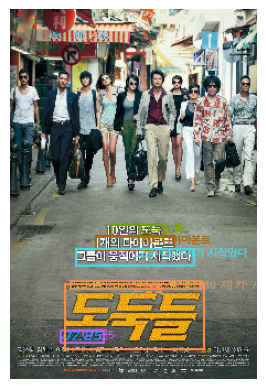

FileNotFoundError: [Errno 2] No such file or directory: 'c:/3rd_project/data/etc_nouns.txt'

In [4]:
import tensorflow as tf
from tensorflow.keras.models import load_model

import warnings

# 특정 경고 메시지 무시
warnings.filterwarnings("ignore", category=UserWarning)

X = np.load('c:/3rd_project/data/images/movie/X_total_color.npy')
y = np.load('c:/3rd_project/data/images/movie/y_total_color.npy')

sample_img = X[555]
sample_gen = y[555]

img = sample_img
genre = sample_gen

################################### 이미지 특징 추출 ############################################
## 이미지 텍스트 추출
ocr = Ocr(img)
ocr.text_detect()
i2t_text = ocr.image_to_text()

gn = GetNouns(i2t_text)
nouns = gn.get_nouns_list()
act_nouns = gn.read_file('c:/3rd_project/data/act_nouns.txt')
ani_nouns = gn.read_file('c:/3rd_project/data/ani_nouns.txt')
com_nouns = gn.read_file('c:/3rd_project/data/com_nouns.txt')
dra_nouns = gn.read_file('c:/3rd_project/data/dra_nouns.txt')
hor_nouns = gn.read_file('c:/3rd_project/data/hor_nouns.txt')
etc_nouns = gn.read_file('c:/3rd_project/data/etc_nouns.txt')
text_freq = gn.get_nouns_freq(act_nouns, ani_nouns, com_nouns, dra_nouns, hor_nouns, etc_nouns)

## 이미지 특징 추출
ic = ImageCharacteristic(img)
ic.show_origin()
ic.color_hist()
brightness = ic.brightness()
main_5_colors = ic.main_5_color()
i_s = ic.image_segmentation()

print(f"{'='*30}이미지 특징{'='*30}")
# print(f"장르별 단어 빈도수 : act_freq : {text_freq[0]}\tani_freq : {text_freq[1]}\tcom_freq : {text_freq[2]}\tdra_freq : {text_freq[3]}\thor_freq : {text_freq[4]}\tetc_freq : {text_freq[5]}")
print(f"장르별 단어 빈도수 : act_freq : {text_freq[0]}\tani_freq : {text_freq[1]}\tcom_freq : {text_freq[2]}\tdra_freq : {text_freq[3]}\thor_freq : {text_freq[4]}")
print(f"이미지 밝기 : {brightness}")
print(f"이미지 메인 색상 : {main_5_colors}")
print(f"이미지 개체 : \nvehicle : {i_s[0]}\nfood : {i_s[1]}\nanimal : {i_s[2]}\nbird : {i_s[3]}\nperson : {i_s[4]}\nobjects : {i_s[5]}\nelectronic_products : {i_s[6]}\ncomputer : {i_s[7]}\nsport : {i_s[8]}\nweapon : {i_s[9]}\neating_utensil : {i_s[10]}\nbag : {i_s[11]}\netc : {i_s[12]}")

################################### 추출 데이터 전처리 ###########################################
dp = DataProcessing()
input_data = dp.change_data(text_freq, brightness, main_5_colors, i_s)
# print(f"예측 데이터 : \n{input_data}")

####################################### 장르 예측 ###############################################
labels = {0: '기타',
          1: '공포(호러)',
          2: '드라마',
          3: '애니메이션',
          4: '액션',
          5: '코미디'
          }

model = load_model('c:/3rd_project/model/CNN_231009_a.h5')

predictions = model.predict(input_data)

print(f"                   etc      horror      drama       ani     action       comedy")
print(f"장르별 확률 : {predictions[0]}")


# 상위 3개 클래스의 인덱스 가져오기
top3_indices = np.argsort(predictions[0])[::-1][:3]

# 상위 3개 클래스 출력
top3_classes = [labels[i] for i in top3_indices]
print("상위 3개 클래스:", top3_classes)


# 예측 결과를 클래스 레이블로 변환
predicted_label = labels[np.argmax(predictions[0])]


# 정답 결과와 예측 결과를 출력
print(f"정답 : {y[555]}")
print(f"예측 : {predicted_label}\n")

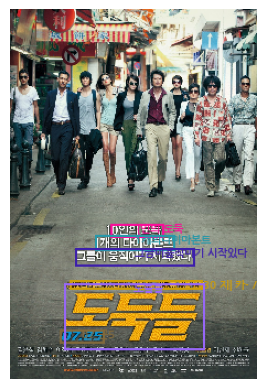


0: 448x320 1 handbag, 10 persons, 0.0ms
Speed: 0.0ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 320)


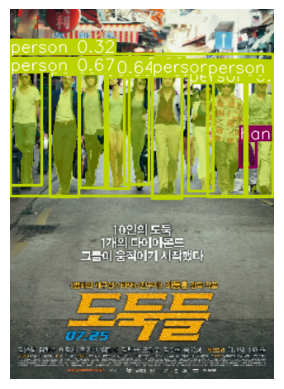

예측 데이터 : 
[[          0           0           0           0          10           0           0           0           0           0           0           1           0      0.4621      0.8118      0.8549      0.8353      0.1725      0.1725      0.1412      0.5098      0.5569      0.5412      0.1216      0.6392       0.902
       0.3294      0.3608      0.3725          31           0           0           0           0           0]]
1/1 [==============================] - 0s 134ms/step
                    기타     호러(공포)     드라마     애니메이션     액션        코미디
장르별 확률 : [    0.11938    0.092237     0.18388     0.21978     0.13144     0.25328]
상위 3개 클래스: ['코미디', '애니메이션', '드라마']

정답 : 액션
CNN 예측 : 코미디
Logistic 예측 : 액션
Tree 예측 : 드라마
RF 예측 : 액션
KNN 예측 : 액션
SVM 예측 : 액션


In [8]:
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model

import warnings

# 특정 경고 메시지 무시
warnings.filterwarnings("ignore", category=UserWarning)

# X = np.load('c:/3rd_project/data/images/movie/X_total_color.npy')
# y = np.load('c:/3rd_project/data/images/movie/y_total_color.npy')

num = 555
sample_img = X[num]
sample_gen = y[num]

img = sample_img
genre = sample_gen



################################### 이미지 특징 추출 ############################################
## 이미지 텍스트 추출
ocr = Ocr(img)
ocr.text_detect()
i2t_text = ocr.image_to_text()

gn = GetNouns(i2t_text)
nouns = gn.get_nouns_list()
# print(f"nouns : {nouns}")
act_nouns = gn.read_file('c:/3rd_project/data/act_nouns.txt')
ani_nouns = gn.read_file('c:/3rd_project/data/ani_nouns.txt')
com_nouns = gn.read_file('c:/3rd_project/data/com_nouns.txt')
dra_nouns = gn.read_file('c:/3rd_project/data/dra_nouns.txt')
hor_nouns = gn.read_file('c:/3rd_project/data/hor_nouns.txt')
etc_nouns = gn.read_file('c:/3rd_project/data/etc_nouns.txt')
text_freq = gn.get_nouns_freq(act_nouns, ani_nouns, com_nouns, dra_nouns, hor_nouns, etc_nouns)

## 이미지 특징 추출
ic = ImageCharacteristic(img)
brightness = ic.brightness()
main_5_colors = ic.main_5_color()
i_s = ic.image_segmentation()


################################### 추출 데이터 전처리 ###########################################
dp = DataProcessing()
input_data = dp.change_data(text_freq, brightness, main_5_colors, i_s)
input_data_2d = input_data.reshape(input_data.shape[0], -1)
print(f"예측 데이터 : \n{input_data_2d}")

####################################### 장르 예측 ###############################################
labels = {0: '기타',
          1: '공포(호러)',
          2: '드라마',
          3: '애니메이션',
          4: '액션',
          5: '코미디'
          }

model_logistic = joblib.load("c:/3rd_project/model/logistic_model.pkl")
model_tree = joblib.load('c:/3rd_project/model/tree_model.pkl')
model_rf = joblib.load('c:/3rd_project/model/random_forest_model.pkl')
model_knn = joblib.load('c:/3rd_project/model/knn_model.pkl')
model_svm = joblib.load('c:/3rd_project/model/svm_classifier.pkl')
model_cnn = load_model('c:/3rd_project/model/CNN_231009_a.h5')


predictions_cnn = model_cnn.predict(input_data)
predictions_logistic = model_logistic.predict(input_data_2d)
predictions_tree = model_tree.predict(input_data_2d)
predictions_rf = model_rf.predict(input_data_2d)
predictions_knn = model_knn.predict(input_data_2d)
predictions_svm = model_svm.predict(input_data_2d)


print(f"                    기타     호러(공포)     드라마     애니메이션     액션        코미디")
print(f"장르별 확률 : {predictions_cnn[0]}")

# 상위 3개 클래스의 인덱스 가져오기
top3_indices_cnn = np.argsort(predictions_cnn[0])[::-1][:3]

# 상위 3개 클래스 출력
top3_classes_cnn = [labels[i] for i in top3_indices_cnn]
print("상위 3개 클래스:", top3_classes_cnn)

# 예측 결과를 클래스 레이블로 변환
predicted_label_cnn = labels[np.argmax(predictions_cnn[0])]
predicted_label_logistic = labels[predictions_logistic[0]]
predicted_label_tree = labels[predictions_tree[0]]
predicted_label_rf = labels[predictions_rf[0]]
predicted_label_knn = labels[predictions_knn[0]]
predicted_label_svm = labels[predictions_svm[0]]

# 정답 결과와 예측 결과를 출력
print(f"\n정답 : {sample_gen}")
print(f"CNN 예측 : {predicted_label_cnn}")
print(f"Logistic 예측 : {predicted_label_logistic}")
print(f"Tree 예측 : {predicted_label_tree}")
print(f"RF 예측 : {predicted_label_rf}")
print(f"KNN 예측 : {predicted_label_knn}")
print(f"SVM 예측 : {predicted_label_svm}")

In [6]:
num = 456
print(type(X[num]))
print(X[num].shape)
print(X[num])

<class 'numpy.ndarray'>
(336, 224, 3)
[[[116 172 176]
  [ 80 129 129]
  [ 84 135 135]
  ...
  [101 149 151]
  [104 152 154]
  [129 175 175]]

 [[136 188 193]
  [ 81 129 130]
  [102 154 154]
  ...
  [108 156 158]
  [101 149 151]
  [134 182 182]]

 [[100 152 157]
  [ 86 134 135]
  [111 163 163]
  ...
  [114 160 163]
  [101 146 149]
  [ 99 145 143]]

 ...

 [[248 233 228]
  [248 233 228]
  [248 233 228]
  ...
  [248 233 228]
  [248 233 228]
  [248 233 228]]

 [[248 233 228]
  [248 233 228]
  [248 233 228]
  ...
  [248 233 228]
  [248 233 228]
  [248 233 228]]

 [[248 233 228]
  [248 233 228]
  [248 233 228]
  ...
  [248 233 228]
  [248 233 228]
  [248 233 228]]]


In [7]:
test = [1,2,3,4,5,6,7,8,9,10]
print(test[0])
print(test[1:])

1
[2, 3, 4, 5, 6, 7, 8, 9, 10]
